# Intelligenza Artificiale tra Geometria e Fisica

> Autore: [Riccardo Finotello](mailto:riccardo.finotello@gmail.com)
>
> Codice disponibile su [GitHub](https://github.com/thesfinox/demo-liceo).

In questa dimostrazione l'idea è di costruire un piccolo modello di **Intelligenza Artificiale** in grado di riconoscere **cifre scritte a mano**.

La dimostrazione, per motivi didattici, è tuttavia *divisa in due parti*:

1. la **prima parte** introduce un semplice compito risolvibile con **Machine Learning** nel senso classico del termine,
2. la **seconda parte** prevede l'uso di metodi più avanzati per costruire una **AI** funzionante.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, GlobalMaxPool2D, MaxPool2D, Activation, UpSampling2D
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import Image
from utils.utils import *
from utils.plots import *

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.keras.backend as K

# set the random seed
np.random.seed(123)
tf.random.set_seed(123)

# set memory growth
set_memory_growth()

# set random seed
rs = np.random.RandomState(0)

## Machine Learning

Il primo compito che affrontiamo è quello di **classificare** dei fiori nelle loro diverse **specie** date le loro **caratteristiche**.

> L'idea è mostrare che MACHINE LEARNING = TRASFORMAZIONE in modo tale da avere una **rappresentazione conveniente** per poter suddividere gli elementi nelle loro **classi**.

In [2]:
# load the Iris dataset
X, y = load_iris(return_X_y=True, as_frame=True)

# divide train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=rs)

Come ogni buon **data scientist**, prima di tutto osserviamo i dati per renderci conto cosa abbiamo di fronte.

In [3]:
# show the first 10 entries
X_train.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
85,6.0,3.4,4.5,1.6
30,4.8,3.1,1.6,0.2
101,5.8,2.7,5.1,1.9
94,5.6,2.7,4.2,1.3
64,5.6,2.9,3.6,1.3
89,5.5,2.5,4.0,1.3
91,6.1,3.0,4.6,1.4
125,7.2,3.2,6.0,1.8
48,5.3,3.7,1.5,0.2
13,4.3,3.0,1.1,0.1


In [4]:
# provide the target labels (with names)
names        = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
y_test_dummy = pd.get_dummies(y_test.replace(names)).values

# show the first 10 labels
y_train.replace(names).head(10)

85     versicolor
30         setosa
101     virginica
94     versicolor
64     versicolor
89     versicolor
91     versicolor
125     virginica
48         setosa
13         setosa
Name: target, dtype: object

### Approccio "Unsupervised"

Il primo approccio che utilizzeremo è di tipo **unsupervised**. In altre parole, non forniamo alla macchina le risposte, ma ci aspettiamo che la macchina riesca a *trovare un senso* nei dati, ossia riesca a distinguere per noi se alcuni dati sono *diversi* da altri.

> Un approccio **unsupervised** non è in generale in grado di generare *la risposta* al problema! Fornisce una linea guida, dal quale poi proseguire. Non essendo a conoscenza del risultato *giusto* è infatti difficile poter ottenere *la risposta*.

#### Clustering

Uno degli algoritmi più diffusi per sondare la **struttura** dei dati è un algoritmo di *clustering*. Il suo compito è formare dei **gruppi** di dati simili.

In [5]:
# run KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=rs)
t_labs = pd.Series(kmeans.fit_predict(X_train), name='target')

#### Visualizzazione con PCA

Abbiamo visto prima che i dati in ingresso sono dei **vettori con 4 dimensioni**. Questo significa che, in generale, disegnare questi dati su un grafico risulta essere un compito impossibile. Esistono tuttavia altri metodi **unsupervised** che **riducono la dimensionalità** dei vettori. Il loro compito è duplice:

1. possono essere usati per ridurre i dati a disposizione, cercando di estrarre solo quelli **più significativi**,
2. possono essere usati per ridurre a 2 le dimensioni dei dati.

In questo primo tentativo noi useremo **PCA** (*Principal Components Analysis*) per ridurre a 2 dimensioni i dati e disegnare i grafici.

In [6]:
# reduce dimensionality with PCA
pca  = PCA(n_components=2, random_state=rs)
t_cp = pd.DataFrame(pca.fit_transform(X_train), columns=['pc_1', 'pc_2'])
d_cp = pd.DataFrame(pca.transform(X_test), columns=['pc_1', 'pc_2'])

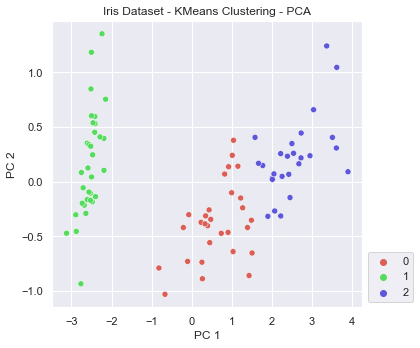

In [7]:
_, ax = subplots()

plot_dimensionality_reduced(t_cp,
                            'pc_1',
                            'pc_2',
                            labs=(t_labs, 3),
                            xlab='PC 1',
                            ylab='PC 2',
                            title='Iris Dataset - KMeans Clustering - PCA',
                            pal='hls',
                            ax=ax
                           )

#### Visualizzazione con TSNE

PCA tuttavia non è il solo algoritmo in grado di fare questo. Un altro metodo interessante si chiama **t-SNE**, ed anziché trasformare geometricamente i dati, esso cerca di *imparare* la forma dello spazio migliore per **rappresentare i dati**. In pratica opera "cambiando la forza di gravità" dello spazio e ne modifica la forma, proprio come la **forza di gravità*.

In [8]:
# compute manifold learning with tSNE
tsne  = TSNE(n_components=2, random_state=rs, n_jobs=-1)
t_rep = pd.DataFrame(tsne.fit_transform(X_train), columns=['tsne_1', 'tsne_2'])
d_rep = pd.DataFrame(tsne.fit_transform(X_test), columns=['tsne_1', 'tsne_2'])

C:\Users\RF265700\Anaconda3\envs\camelia\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\RF265700\Anaconda3\envs\camelia\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\RF265700\Anaconda3\envs\camelia\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\RF265700\Anaconda3\envs\camelia\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


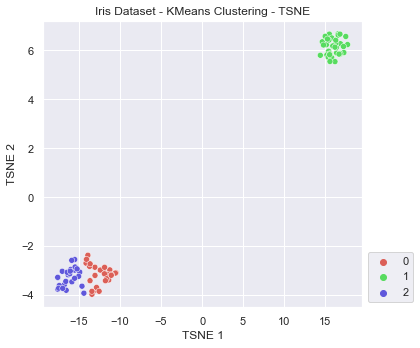

In [9]:
_, ax = subplots()

plot_dimensionality_reduced(t_rep,
                            'tsne_1',
                            'tsne_2',
                            labs=(t_labs, 3),
                            xlab='TSNE 1',
                            ylab='TSNE 2',
                            title='Iris Dataset - KMeans Clustering - TSNE',
                            pal='hls',
                            ax=ax
                           )

#### Feature Engineering e Data Science

Non soddisfatti? Proviamo a **generare** un maggior numero di dati **a partire da ciò che abbiamo**. Molto probabilmente la macchina non è in grado di sfruttare al massimo l'informazione contenuta nei dati.

> In **data science** così come la **fisica** il "codice" (o la formula) non sono mai sufficienti, ma è necessario **sempre** un grande lavoro di raccolta e analisi dei dati. L'informazione è infatti solitamente nascosta. L'uso dell'intelligenza artificiale può solo **mitigare** il problema, ma in generale è meglio affrontarlo.

New shape of the data: (90, 14)


C:\Users\RF265700\Anaconda3\envs\camelia\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\RF265700\Anaconda3\envs\camelia\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


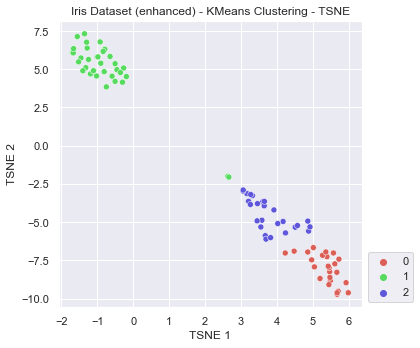

In [10]:
# create polynomial features
pol              = PolynomialFeatures(degree=2, include_bias=False)
X_train_enhanced = pol.fit_transform(X_train)

print(f'New shape of the data: {X_train_enhanced.shape}')

# fit KMeans
t_labs_enhanced = pd.Series(kmeans.fit_predict(X_train_enhanced), name='target')

# compute manifold learning with tSNE
tsne_enhanced  = TSNE(n_components=2, random_state=rs, n_jobs=-1)
t_rep_enhanced = pd.DataFrame(tsne.fit_transform(X_train_enhanced), columns=['tsne_1', 'tsne_2'])

# plot the result
_, ax = subplots()

plot_dimensionality_reduced(t_rep_enhanced,
                            'tsne_1',
                            'tsne_2',
                            labs=(t_labs_enhanced, 3),
                            xlab='TSNE 1',
                            ylab='TSNE 2',
                            title='Iris Dataset (enhanced) - KMeans Clustering - TSNE',
                            pal='hls',
                            ax=ax
                           )

### Approccio "Supervised"

L'approccio **supervised** è forse il più intuitivo da comprendere.
Si tratta dopotutto di *imparare* qualcosa attraverso una grande serie di **errori** e **correzioni**.
Alla macchina in questo caso vengono fornite **alcune** risposte corrette: viene individuato un sottoinsieme di elementi che vengono usati per *imparare* qualcosa, mentre altri elementi vengono utilizzati per *controllare* che la macchina stia imparando correttamente.

> Spesso la macchina tende a riprodurre un risultato senza realmente "capire" cosa sta facendo. Pertanto è **molto** importante sempre avere una strategia di *validazione* che funzioni ed usarla correttamente.

#### Curva logistica

La curva logistica è alla base di un mucchio di applicazionie, quali biologia, fisica, finanza, etc.

![](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)

In questo contensto viene usata per modellizzare una **probabilità**, dato che assegna un numero nell'intervallo $[0, 1]$ a dei numeri reali.

> Il concetto di probabilità è estremamente importante. La macchina infatti, durante il suo apprendimento, impara a gestire con quale probabilità è atteso un certo risultato, e sceglie di conseguenza.

Da notare che, soprattutto nel caso delle reti neurali, diversi tentativi sono stati fatti per cercare di capire *come* la macchina impari.
Questo tipo di studi è condotto utilizzando delle modellizzazioni provenienti dalla **fisica** (teorica in particolare) come lo studio della *teoria dei campi* e delle *matrici casuali*.

> È infatti estremamente interessante cercare di capire il legame tra Intelligenza Artificiale e la Fisica, dato che molti elementi sono effettivamente in comune e possono portare ad una migliore comprensione di *come* l'AI funziona.

In [11]:
# compute logistic regression
lr = LogisticRegression(C=1.0e5, n_jobs=-1)
lr = lr.fit(X_train, y_train)

Avendo "allenato" la macchina su alcuni elementi, ora procediamo a predire il risultato su **quelli che non sono mai stati visti** dalla macchina.

In [12]:
# predict probabilities
y_pred = pd.Series(lr.predict(X_test), name='prediction')
y_prob = lr.predict_proba(X_test)
ident  = pd.Series(y_pred.values == y_test.values, name='test').replace({True: 'ok', False: 'wrong'})

#### Visualizzazione con PCA

Come in precedenza, procediamo a *ridurre la dimensionalità* dei vettori in ingresso e guardiamo il risultato. Questa volta è disponibile la *verità* (in Inglese, **ground truth**) per confrontare quanto l'algoritmo stia imparando bene.

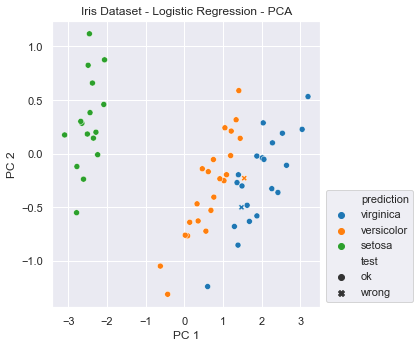

In [13]:
_, ax = subplots()

plot_dimensionality_reduced(d_cp,
                            'pc_1',
                            'pc_2',
                            labs=(y_pred.replace(names), 3),
                            style=ident,
                            xlab='PC 1',
                            ylab='PC 2',
                            title='Iris Dataset - Logistic Regression - PCA',
                            ax=ax
                           )

#### Efficacia della classificazione

L'efficacia del processo di apprendimento può e deve essere **misurata** con delle funzioni che vengono chiamate *metriche* (in questo caso, non sono quelle della fisica).

In questo caso ne scegliamo più di una:

1. **accuratezza**: \begin{equation} \frac{\text{predizioni corrette}}{\text{numero di predizioni}} \end{equation}
2. **precisione**: \begin{equation} \frac{\text{positivi veri}}{\text{totale di positivi predetti}} \end{equation}
3. **recall** (o *true positive rate*): \begin{equation} \frac{\text{positivi veri}}{\text{totale di positivi effettivi}} \end{equation}

In sostanza, l'**accuratezza** misura la bontà generale della predizione, la **precisione** quante volte la predizione "positiva" è corretta, il **recall** quante volte riuscite a predire la classe positiva.

Per intenderci, supponete di voler predire se il risultato di un test è positivo: se il vostro test predice correttamente un gran numero di positivi, allora è **preciso**; se il vostro test non si lascia mai sfuggire un positivo, allora ha un grande **recall**. È da notare che tuttavia queste metriche non sono indipendenti: un test **molto preciso** avrà **basso recall**, e viceversa.

L'accuratezza gioca un ruolo particolare. Supponete che il numero di positivi sia solo l'1% del totale. Se la vostra macchina predice sempre *negativo*, qual è la sua accuratezza? È un test attendibile? Cosa si può dire di precisione e recall?

[RISPOSTE: 99%; NO; BASSA PRECISIONE, BASSO RECALL]

In [14]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {100 * acc:.2f}%')

pre = precision_score(y_test, y_pred, average='micro')
print(f'Precision: {100 * pre:.2f}%')

rec = recall_score(y_test, y_pred, average='micro')
print(f'Recall: {100 * pre:.2f}%')

Accuracy: 96.67%
Precision: 96.67%
Recall: 96.67%


Per meglio illustrare la dipendenza delle due metriche, possiamo studiare la loro variabilità in funzione di diverse soglie sulla probabilità.

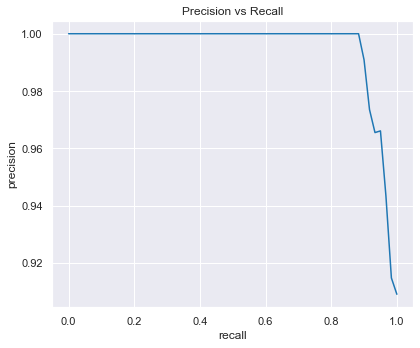

In [15]:
p, r, _ = precision_recall_curve(y_test_dummy.ravel(), y_prob.ravel())

_, ax = subplots()

plot_precision_recall(p, r, ax)

Una maniera per ovviare al problema può essere studiare *cumulativamente* gli effetti delle due metriche, calcolando l'area della curva sottesa dal numero veri positivi e il numero di falsi positivi. La curva è nota come **Receiver Operating Characteristic** (ROC). Più l'area si avvicina a $1$, migliore è la predizione, mentre $0.5$ (la diagonale nel grafico) rappresenta un classificatore che tira a infovinare.

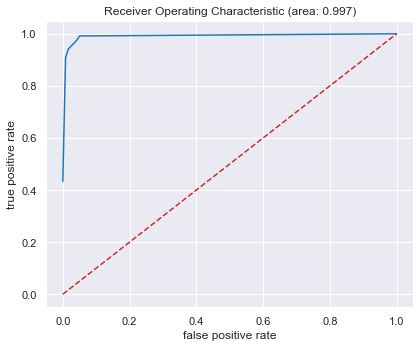

In [16]:
fpr, tpr, _ = roc_curve(y_test_dummy.ravel(), y_prob.ravel())
score       = roc_auc_score(y_test_dummy.ravel(), y_prob.ravel())

_, ax = subplots()

plot_roc_curve(fpr, tpr, score, ax)

### Unsupervised + Supervised

Gli approcci *supervised* e *unsupervised* non sono esclusivi, ma possono essere combinati tra loro.
Ad esempio, considerate due casi molto diversi ma con un'idea di fondo simile:

- avete a disposizione $10^6$ di vettori di dimensione $100$ e volete cercare di predire una particolare classe: potete usare un algoritmo **unsupervised** per ridurre il numero di dati, e poi calcolare la classificazione **supervised**;
- avete a disposizione molti segnali acustici corrotti da molto rumore: usate un algoritmo **unsupervised** per *pulire* i dati, ed operate successivamente **supervised** per calcolare la quantità desiderata.

#### Curva logistica + TSNE

Il primo tentativo che faremo è di "allenare" una curva logistica sui dati t-SNE.

In [17]:
lr = LogisticRegression(C=1.0e5, n_jobs=-1)
lr = lr.fit(t_rep, y_train)

In [18]:
y_pred = pd.Series(lr.predict(d_rep), name='prediction')
y_prob = lr.predict_proba(d_rep)
ident  = pd.Series(y_pred.values == y_test.values, name='test').replace({True: 'ok', False: 'wrong'})

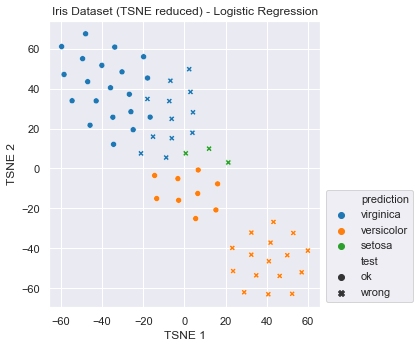

In [19]:
_, ax = subplots()

plot_dimensionality_reduced(d_rep,
                            'tsne_1',
                            'tsne_2',
                            labs=(y_pred.replace(names), 3),
                            style=ident,
                            xlab='TSNE 1',
                            ylab='TSNE 2',
                            title='Iris Dataset (TSNE reduced) - Logistic Regression',
                            ax=ax
                           )

Il grafico parla da sé: l'aver *perso* dell'informazione per strada ha fatto sì che la classificazione abbia perso molto in accuratezza.

In [20]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {100 * acc:.2f}%')

pre = precision_score(y_test, y_pred, average='micro')
print(f'Precision: {100 * pre:.2f}%')

rec = recall_score(y_test, y_pred, average='micro')
print(f'Recall: {100 * pre:.2f}%')

Accuracy: 48.33%
Precision: 48.33%
Recall: 48.33%


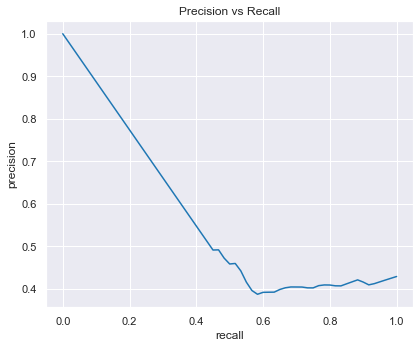

In [21]:
p, r, _ = precision_recall_curve(y_test_dummy.ravel(), y_prob.ravel())

_, ax = subplots()

plot_precision_recall(p, r, ax)

Tanto è vero che, a questo punto, il machine learning non è meglio che tirare a indovinare.

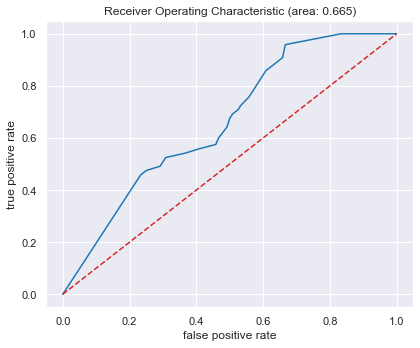

In [22]:
fpr, tpr, _ = roc_curve(y_test_dummy.ravel(), y_prob.ravel())
score       = roc_auc_score(y_test_dummy.ravel(), y_prob.ravel())

_, ax = subplots()

plot_roc_curve(fpr, tpr, score, ax)

Un modo per cercare di capire cosa il machine learning stia facendo è studiare i **contorni decisionali** (in Inglese, *decision boundaries*), ossia dove la macchina divide una classe dall'altra.

C:\Users\RF265700\Anaconda3\envs\camelia\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


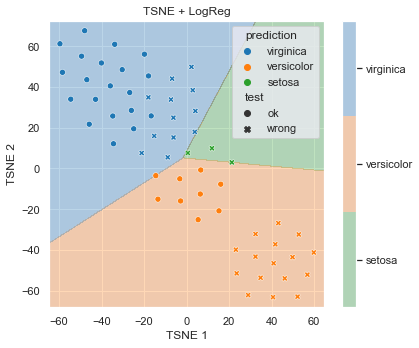

In [23]:
x = np.arange(d_rep['tsne_1'].min() - 5.0, d_rep['tsne_1'].max() + 5.0, 0.1)
y = np.arange(d_rep['tsne_2'].min() - 5.0, d_rep['tsne_2'].max() + 5.0, 0.1)
x_grid, y_grid = np.meshgrid(x, y)
grid = np.c_[x_grid.ravel(), y_grid.ravel()]
bnd  = lr.predict(grid).reshape(x_grid.shape)

fig, ax = subplots()

c = ax.contourf(x_grid,
                y_grid,
                bnd,
                levels=range(-1, 3),
                colors=sns.color_palette(n_colors=3)[::-1],
                alpha=0.3
               )

cbar = fig.colorbar(c, ticks=np.arange(3) - 0.5, ax=ax)
cbar.set_ticklabels(names)

sns.scatterplot(data=d_rep,
                x='tsne_1',
                y='tsne_2',
                hue=y_pred.replace(names),
                style=ident,
                ax=ax
               )

ax.set(xlabel='TSNE 1', ylabel='TSNE 2', title='TSNE + LogReg')

plt.tight_layout()

In questo caso la rappresentazione data in input non è la migliore. Il machine learning, infatti, non riesce a suddividere correttamente in classi i vari elementi, finendo per sbagliare completamente.

#### Curva logistica + PCA

Proviamo ora a cambiare il tipo di trasformazione in input per vedere se riusciamo a trovarne una più adatta. Proviamo ora ad utilizzare **PCA** per rasformare i dati.

In [24]:
lr = LogisticRegression(C=1.0e5, n_jobs=-1)
lr = lr.fit(t_cp, y_train)

In [25]:
y_pred = pd.Series(lr.predict(d_cp), name='prediction')
y_prob = lr.predict_proba(d_cp)
ident  = pd.Series(y_pred.values == y_test.values, name='test').replace({True: 'ok', False: 'wrong'})

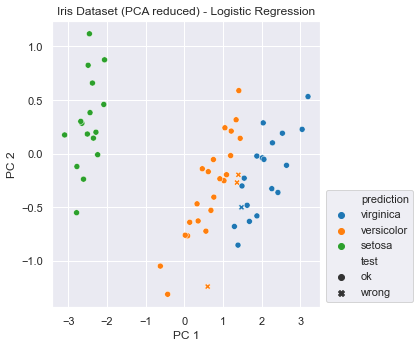

In [26]:
_, ax = subplots()

plot_dimensionality_reduced(d_cp,
                            'pc_1',
                            'pc_2',
                            labs=(y_pred.replace(names), 3),
                            style=ident,
                            xlab='PC 1',
                            ylab='PC 2',
                            title='Iris Dataset (PCA reduced) - Logistic Regression',
                            ax=ax
                           )

Anche in questo caso il grafico parla da sé. L'accurattezza, la precisione e il recall si mantengo *molto alti* nonostante parte della informazione originaria è andata perduta. In questo senso, la rappresentazione è più compatta. Inoltre, perdendo solo qualche punto di accuratezza, il calcolo risulta più veloce e meno dispendioso. Questa è una **pratica standard per l'uso nei dispositivi mobili o in IoT**.

In [27]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {100 * acc:.2f}%')

pre = precision_score(y_test, y_pred, average='micro')
print(f'Precision: {100 * pre:.2f}%')

rec = recall_score(y_test, y_pred, average='micro')
print(f'Recall: {100 * pre:.2f}%')

Accuracy: 93.33%
Precision: 93.33%
Recall: 93.33%


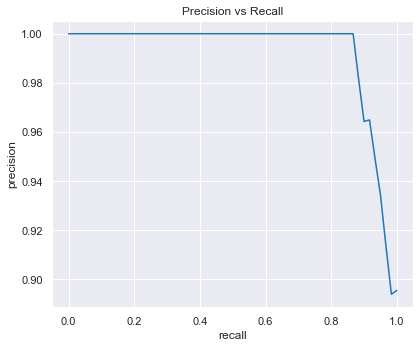

In [28]:
p, r, _ = precision_recall_curve(y_test_dummy.ravel(), y_prob.ravel())

_, ax = subplots()

plot_precision_recall(p, r, ax)

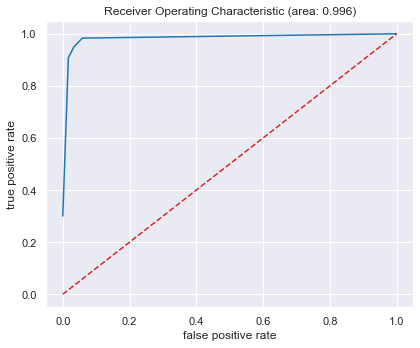

In [29]:
fpr, tpr, _ = roc_curve(y_test_dummy.ravel(), y_prob.ravel())
score = roc_auc_score(y_test_dummy.ravel(), y_prob.ravel())

_, ax = subplots()

plot_roc_curve(fpr, tpr, score, ax)

Come in precedenza, il motivo del successo è da ricercare nel **modo** in cui le operazioni vengono svolte. La rappresentazione tramite PCA è *semplice* da suddividere. Analizzando il grafico sembrerebbe persino che anche un umano avrebbe avuto qualche difficoltà a tracciare i giusti contorni.

C:\Users\RF265700\Anaconda3\envs\camelia\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


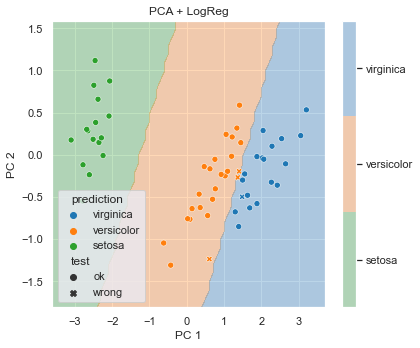

In [30]:
x = np.arange(d_cp['pc_1'].min() - 0.5, d_cp['pc_1'].max() + 0.5, 0.1)
y = np.arange(d_cp['pc_2'].min() - 0.5, d_cp['pc_2'].max() + 0.5, 0.1)
x_grid, y_grid = np.meshgrid(x, y)
grid = np.c_[x_grid.ravel(), y_grid.ravel()]
bnd  = lr.predict(grid).reshape(x_grid.shape)

fig, ax = subplots()

c = ax.contourf(x_grid,
                y_grid,
                bnd,
                levels=range(-1, 3),
                colors=sns.color_palette(n_colors=3)[::-1],
                alpha=0.3
               )

cbar = fig.colorbar(c, ticks=np.arange(3) - 0.5, ax=ax)
cbar.set_ticklabels(names)

sns.scatterplot(data=d_cp,
                x='pc_1',
                y='pc_2',
                hue=y_pred.replace(names),
                style=ident,
                ax=ax
               )

ax.set(xlabel='PC 1', ylabel='PC 2', title='PCA + LogReg')

plt.tight_layout()

## Intelligenza Artificiale?

Passiamo ora a considerare un compito più *complicato*. Ci concentriamo sul **riconoscimento della grafia**, ossia il riconoscimento della scrittura a mano. Si tratta di un compito estremamente importante, che viene svolto ormai ovunque da cellulari, tablet, etc.

In questa demo cercheremo di costruirlo per passi successivi, ricostruendo anche la *storia* di come questo problema è stato approacciato. Arriveremo poi a costruire un piccolo modello di AI capace di risolvere un problema **difficile da risolvere per un umano**.

In [31]:
(X, y), (X_test, y_test) = mnist.load_data()

# pad to have 32 x 32 input
X      = np.pad(X, ((0,0), (2,2), (2,2)))
X_test = np.pad(X_test, ((0,0), (2,2), (2,2)))

In [32]:
X_train = X[:10000, :, :] / 255.0
X_train = X_train.reshape(X_train.shape + (1,))
y_train = y[:10000]

X_val   = X[10000:11000, :, :] / 255.0
X_val   = X_val.reshape(X_val.shape + (1,))
y_val   = y[10000:11000]

X_test  = X_test[:1000, :, :] / 255.0
X_test  = X_test.reshape(X_test.shape + (1,))
y_test  = y_test[:1000]

In [33]:
y_train_oh = np.zeros((y_train.shape[0], 10))
y_val_oh   = np.zeros((y_val.shape[0], 10))
y_test_oh  = np.zeros((y_test.shape[0], 10))

for n, v in enumerate(y_train):
    
    y_train_oh[n, v] = 1
    
for n, v in enumerate(y_val):
    
    y_val_oh[n, v] = 1
    
for n, v in enumerate(y_test):
    
    y_test_oh[n, v] = 1

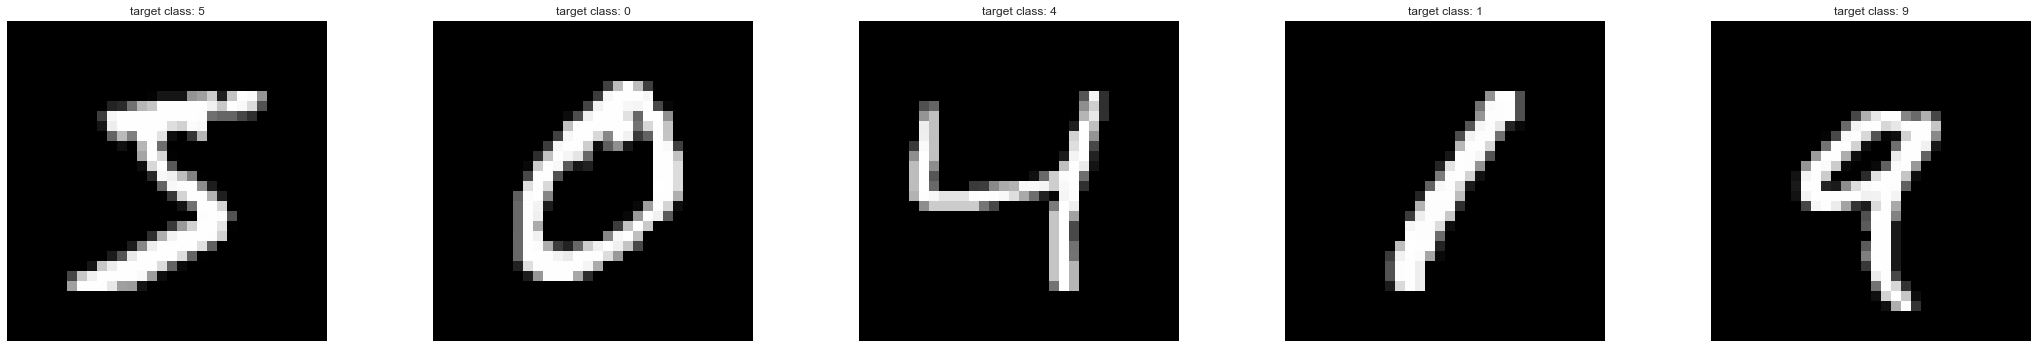

In [34]:
_, ax = subplots(1, 5, sharey=True)

for n in range(5):
    
    sns.heatmap(data=X_train[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    ax[n].set(title=f'target class: {y_train[n]:d}')

plt.tight_layout()

### Logistic Regression

Il primo passo è quello di provare a risolvere il problema come in precedenza, tramite una **regression logistica**. In pratica si tratta di:

1. *vettorizzare* (o "rendere piatti") i numeri scritti a mano,
2. data una certa *sequenza* di valori, calcolare **la probabilità che la sequenza rappresenti un dato numero**.

In [35]:
X_train_flat = X_train.reshape(X_train.shape[0],-1)
X_val_flat   = X_val.reshape(X_val.shape[0],-1)
X_test_flat  = X_test.reshape(X_test.shape[0],-1)

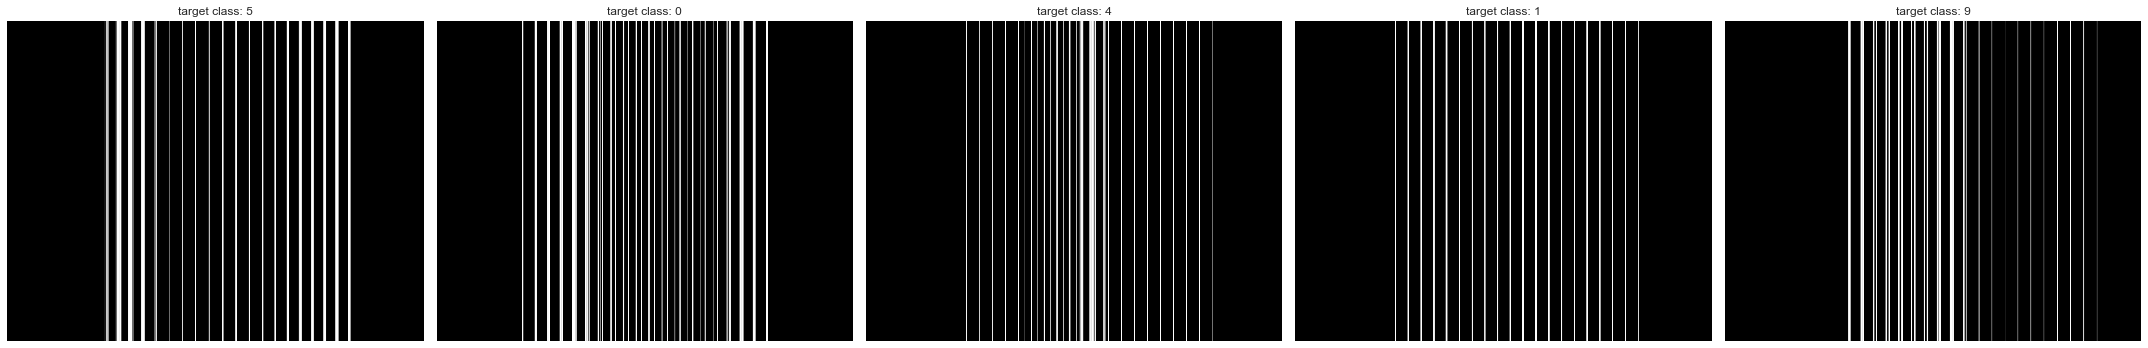

In [36]:
_, ax = subplots(ncols=5, sharey=True)

for n in range(5):
    
    sns.heatmap(data=X_train_flat[n, :].reshape(1, -1),
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=False,
                ax=ax[n]
               )
    
    ax[n].set(title=f'target class: {y_train[n]:d}')
    
plt.tight_layout()

Come stabilito, il primo passo è una curva logistica.

In [37]:
lr = LogisticRegression(C=1.0e5, n_jobs=-1)
lr = lr.fit(X_train_flat, y_train)

In [38]:
y_pred = lr.predict(X_test_flat)

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy score: {100 * acc:.1f}%')

Accuracy score: 86.0%


In questo caso ci occupiamo solo della accuratezza, per semplicità (tenere conto anche di precisione e recall è *molto importante*, ma in questo momento sarebbe eccessivo).

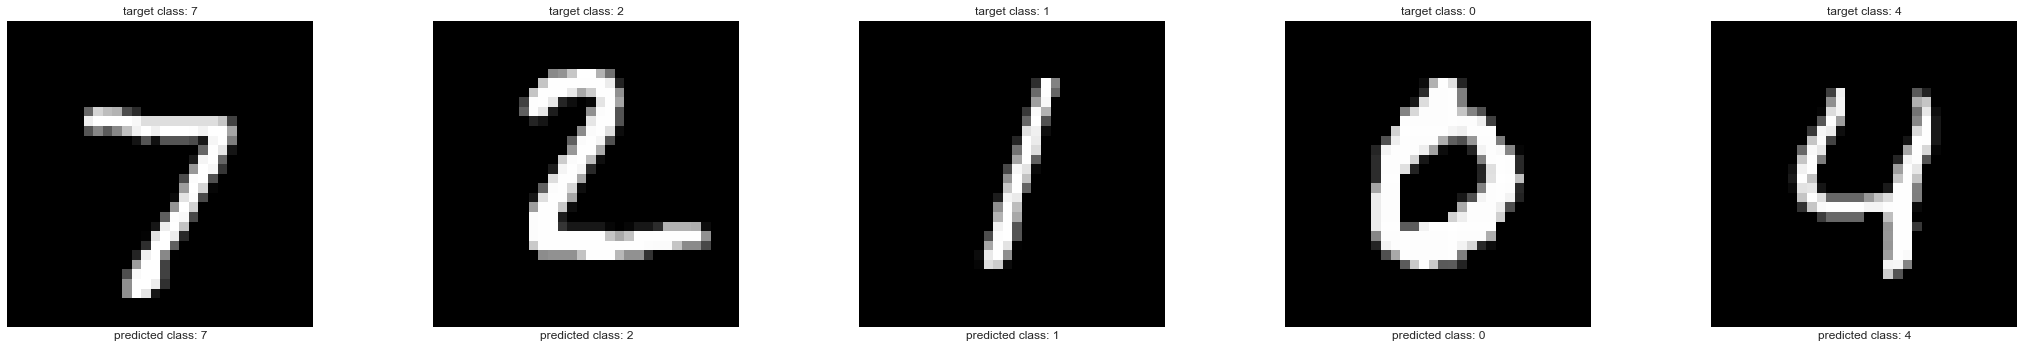

In [39]:
_, ax = subplots(1, 5, sharey=True)

for n in range(5):
    
    sns.heatmap(data=X_test[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    ax[n].set(title=f'target class: {y_test[n]:d}',
              xlabel=f'predicted class: {y_pred[n]:d}'
             )
    
plt.tight_layout()

Il risultato è davvero molto soddisfacente. Per buona parte degli elementi cosiddetti *di test*, la predizione è corretta.

Possiamo fare di meglio?

### Multi-Layered Perceptron

L'idea del **multi-layered perceptron** non è poi così nuova. Già nel 1957 Rosenblatt introdusse il *percettrone* come modello di apprendimento umano (in parte l'analogia reti neurali - cervello nasce da lì, anche se ciò che oggi chiamiamo *rete neurale* ha ben poco da spartire con il cervello umano).

Il suo principio di funzionamento è basato su una struttura sovrapposta di **regressori logistici** (da qui la necessità di introdurre per primo il modello semplice):

![](https://raw.githubusercontent.com/dvgodoy/dl-visuals/main/Feed-Forward%20Networks/feature_space_1hidden.png)

I vantaggi di questa struttura sono molteplici:

1. permette di **approssimare funzioni non lineari** (con alcuni accorgimenti, come le *attivazioni*) e molto complesse,
2. ha una **derivata calcolabile**, per cui l'errore di approssimazione può essere propagato *indietro* e trasmesso ai coefficienti (**backpropagation**),
3. crea automaticamente delle nuove variabili ad ogni livello in modo tale da decidere in autonomia quali sono più importanti.

In [40]:
K.clear_session()

mlp = Sequential([Dense(128, activation='relu', input_shape=(X_train_flat.shape[-1],)),
                  BatchNormalization(),
                  Dense(10, activation='softmax')
                 ],
                 name='mlp'
                )

mlp.summary()

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 133,002
Trainable params: 132,746
Non-trainable params: 256
_________________________________________________________________


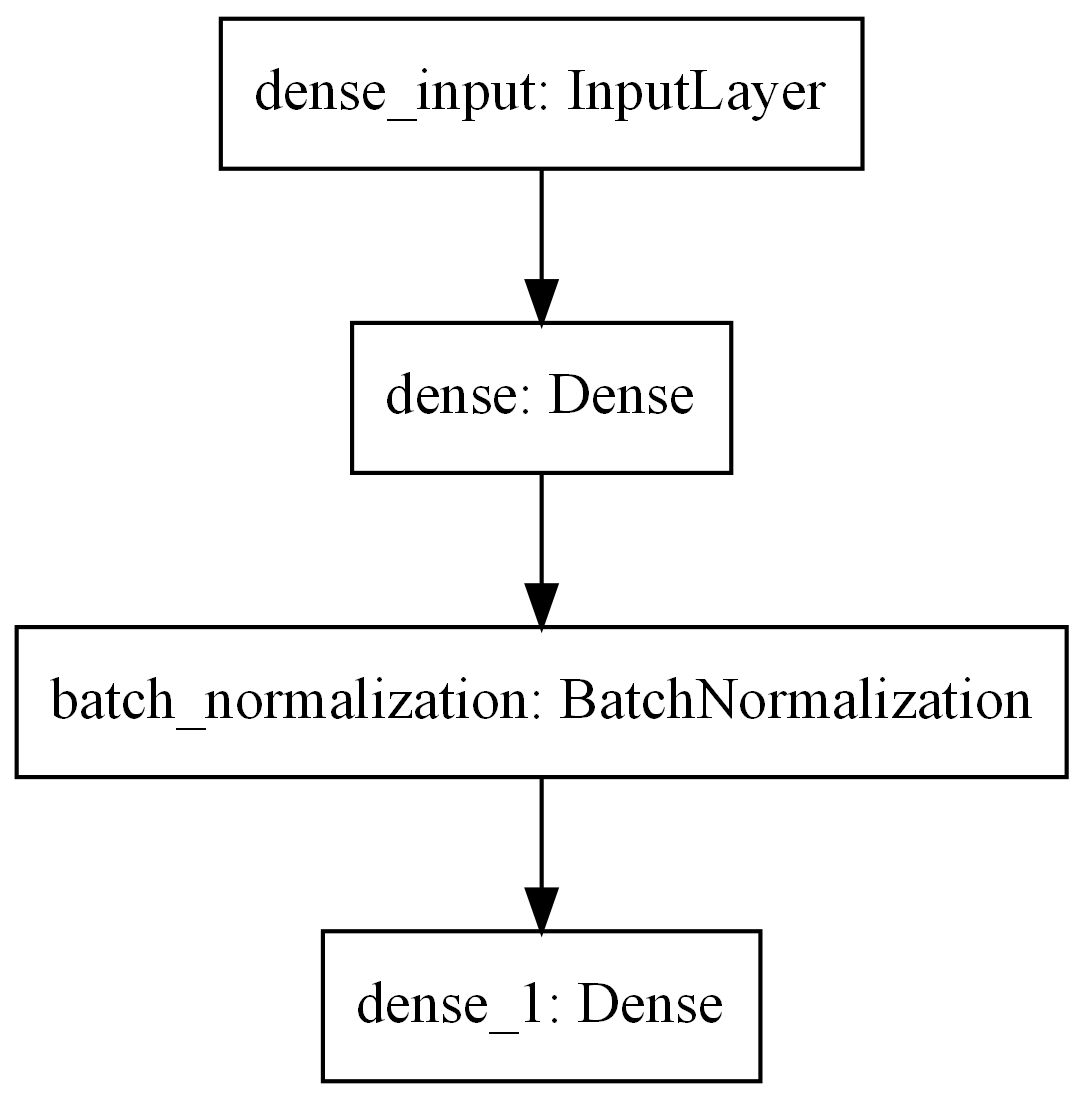

In [41]:
mlp_dot = model_to_dot(mlp, dpi=300)
Image(mlp_dot.create_png(), width=320)

In [42]:
mlp.compile(optimizer=Adam(learning_rate=1.0e-3),
            loss=CategoricalCrossentropy(from_logits=True),
            metrics=[CategoricalAccuracy()]
           )

Il modello di rete neurale ha la necessità di essere "allenato" tramite una procedura iterativa su *epoche*. In pratica ad ogni epoca il modello "tenta" di fare delle predizioni e misura quanto queste sono *distanti* dalla verità. A questo punto apporta gli aggiustamenti necessari e ripete la procedura.

In [43]:
hst = mlp.fit(x=X_train_flat,
              y=y_train_oh,
              batch_size=32,
              epochs=10,
              validation_data=(X_val_flat, y_val_oh),
              callbacks=[ModelCheckpoint('./mlp.h5', save_best_only=True)]
             )

mlp.load_weights('./mlp.h5')

Epoch 1/10


C:\Users\RF265700\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:4869: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


313/313 [==============================] - 1s 1ms/step - loss: 0.4293 - categorical_accuracy: 0.8717 - val_loss: 0.2785 - val_categorical_accuracy: 0.9290
Epoch 2/10
313/313 [==============================] - 0s 801us/step - loss: 0.2023 - categorical_accuracy: 0.9425 - val_loss: 0.1859 - val_categorical_accuracy: 0.9520
Epoch 3/10
313/313 [==============================] - 0s 851us/step - loss: 0.1349 - categorical_accuracy: 0.9626 - val_loss: 0.1647 - val_categorical_accuracy: 0.9560
Epoch 4/10
313/313 [==============================] - 0s 851us/step - loss: 0.1006 - categorical_accuracy: 0.9726 - val_loss: 0.1758 - val_categorical_accuracy: 0.9480
Epoch 5/10
313/313 [==============================] - 0s 851us/step - loss: 0.0804 - categorical_accuracy: 0.9779 - val_loss: 0.1342 - val_categorical_accuracy: 0.9600
Epoch 6/10
313/313 [==============================] - 0s 801us/step - loss: 0.0586 - categorical_accuracy: 0.9858 - val_loss: 0.1609 - val_categorical_accuracy: 0.9550
Epoch

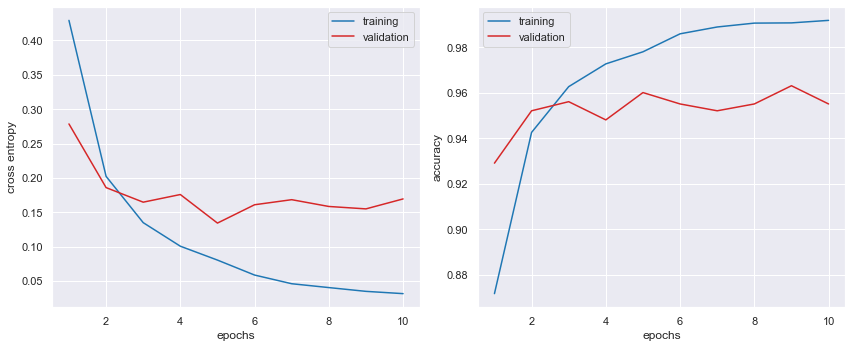

In [44]:
_, ax = subplots(ncols=2)

sns.lineplot(x=range(1, 11),
             y=hst.history['loss'],
             linestyle='-',
             color='tab:blue',
             label='training',
             ax=ax[0]
            )

sns.lineplot(x=range(1, 11),
             y=hst.history['val_loss'],
             linestyle='-',
             color='tab:red',
             label='validation',
             ax=ax[0]
            )

ax[0].set(xlabel='epochs', ylabel='cross entropy')

sns.lineplot(x=range(1, 11),
             y=hst.history['categorical_accuracy'],
             linestyle='-',
             color='tab:blue',
             label='training',
             ax=ax[1]
            )

sns.lineplot(x=range(1, 11),
             y=hst.history['val_categorical_accuracy'],
             linestyle='-',
             color='tab:red',
             label='validation',
             ax=ax[1]
            )

ax[1].set(xlabel='epochs', ylabel='accuracy')

plt.tight_layout()

Il salto di qualità è evidente, rispetto al suo corrispettivo machine learning "semplice". In questo modo le predizioni del modello sono molto più attendibili e possiamo anche cominciare a pensare di usare qualcosa di simile a livello "industriale".

In [45]:
y_pred = mlp.predict(X_test_flat)

acc = accuracy_score(y_test, np.argmax(y_pred, axis=1))
print(f'Accuracy score: {100 * acc:.1f}%')

Accuracy score: 95.0%


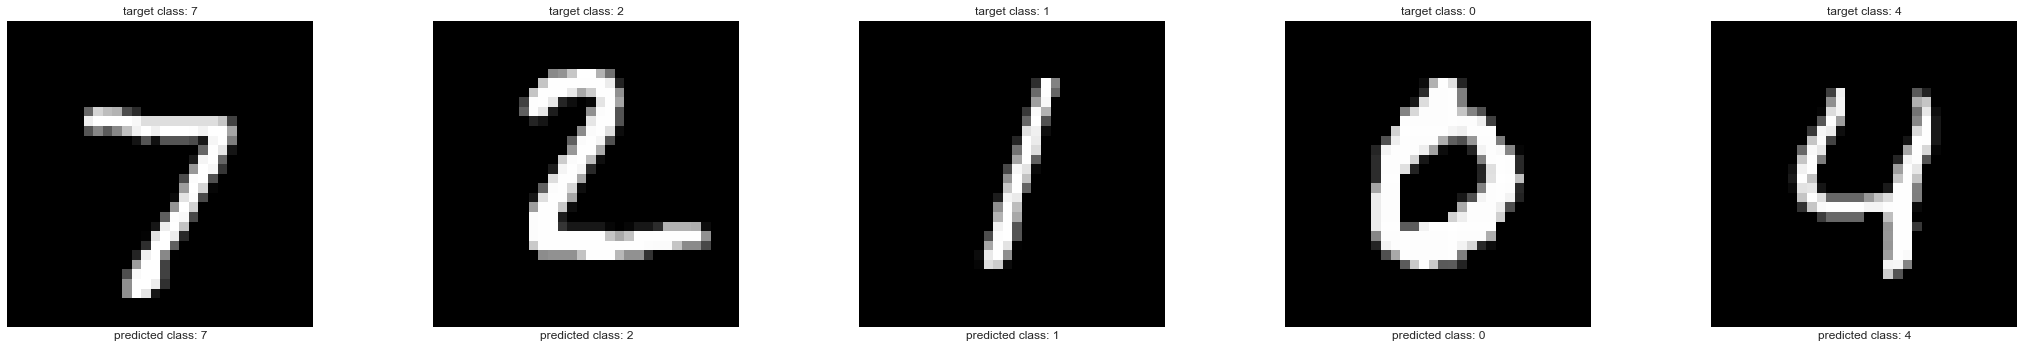

In [46]:
_, ax = subplots(1, 5, sharey=True)

for n in range(5):
    
    sns.heatmap(data=X_test[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    ax[n].set(title=f'target class: {y_test[n]:d}',
              xlabel=f'predicted class: {np.argmax(y_pred, axis=1)[n]:d}'
             )
    
plt.tight_layout()

### Convolutional Neural Network

Le possibilità non sono finite qui, tuttavia. In realtà, qualunque funzione **la cui derivata è calcolabile** permette di "allenare" una rete neurale. E alcune funzioni sono molto meglio di altre.

Nel 1989, Yann LeCun (ora *chief scientist* presso Facebook AI) introduce le **reti neurali convoluzionali** (in Inglese, *Convolutional Neural Network*). L'idea è ben spiegata usando un'analogia con la fisica e lo studio dei segnali:

![](https://www.ligo.org/science/Publication-S6PE/Images/wave_examples_noise.gif)
*da [LIGO Scientific Collaboration](https://www.ligo.org/science/Publication-S6PE/index.php)*

Una convoluzione è un'operazione che può essere usata, ad esempio, per cercare un segnale di una specifica forma:

![](https://upload.wikimedia.org/wikipedia/commons/c/c6/Convolucion_Funcion_Pi.gif)
*da [WikiMedia](https://upload.wikimedia.org/wikipedia/commons/c/c6/Convolucion_Funcion_Pi.gif)*

Questa operazione può essere eseguita anche su immagini se necessario (e nel nostro case, questo è ciò di cui abbiamo bisogno):

![](https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif)
*da [Irhum Shafkat](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)*

L'idea in una rete neurale di questo tipo è che **pixel vicini condividono dei parametri**, ossia permettono di recuperare il significato di piccole porzioni di immagini:

![](https://raw.githubusercontent.com/dvgodoy/dl-visuals/main/Convolutions/conv3.png)
*da [dvgodoy](https://github.com/dvgodoy/dl-visuals)*

In questo senso, una rete neurale convoluzionale **vede come un umano** e decide come caratterizzare l'input basandosi su ciò che seleziona.

In [47]:
K.clear_session()

cnn = Sequential([Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(None, None, 1)),
                  BatchNormalization(),
                  MaxPool2D(pool_size=(2,2)),
                  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                  BatchNormalization(),
                  MaxPool2D(pool_size=(2,2)),
                  Dropout(rate=0.25),
                  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                  BatchNormalization(),
                  MaxPool2D(pool_size=(2,2)),
                  Conv2D(filters=32, kernel_size=(2,2), activation='relu'),
                  BatchNormalization(),
                  Dropout(rate=0.25),
                  Conv2D(filters=10, kernel_size=(1,1)),
                  Activation('softmax')
                 ],
                 name='cnn'
                )

cnn.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   1280      
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 128)   512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 128)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
dropout (Dropout)            (None, None, None, 64)    0       

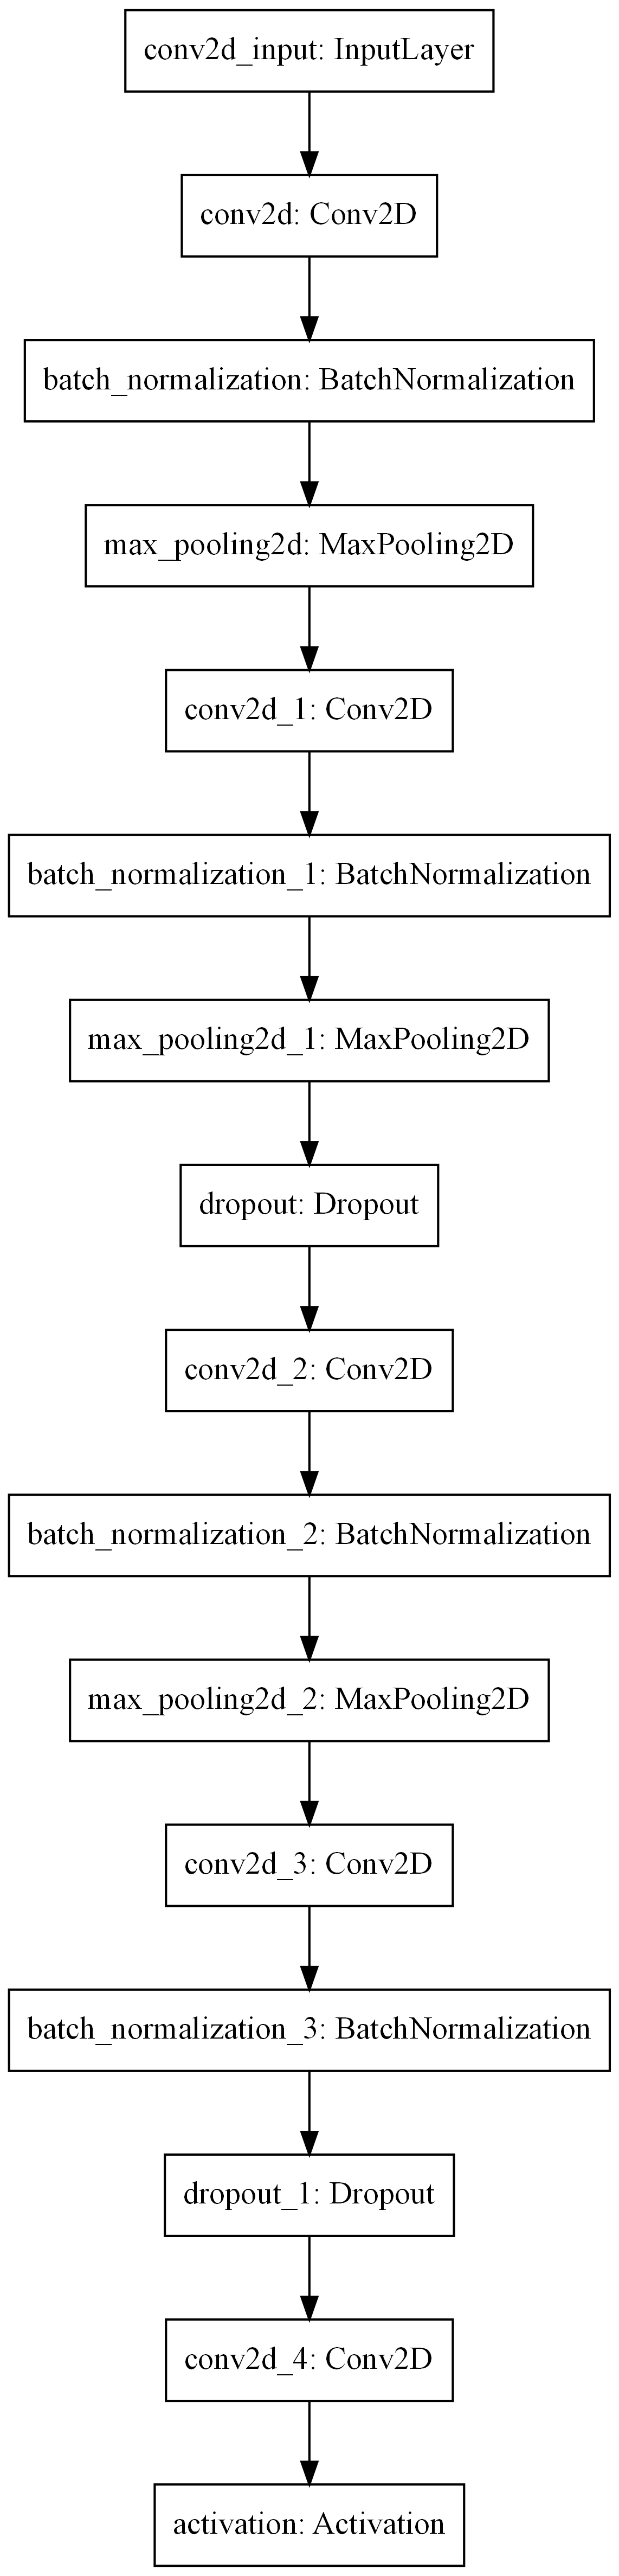

In [48]:
cnn_dot = model_to_dot(cnn, dpi=300)
Image(cnn_dot.create_png(), width=320)

Anche in questo caso l'apprendimento avviene iterativamente, esattamente nello stesso modo.

In [49]:
cnn.compile(optimizer=Adam(learning_rate=1.0e-3),
            loss=CategoricalCrossentropy(),
            metrics=[CategoricalAccuracy()]
           )

hst = cnn.fit(x=X_train,
              y=y_train_oh.reshape(y_train_oh.shape[0], 1, 1, y_train_oh.shape[-1]),
              batch_size=32,
              epochs=10,
              validation_data=(X_val, y_val_oh.reshape(y_val_oh.shape[0], 1, 1, y_val_oh.shape[-1])),
              callbacks=[ModelCheckpoint('./cnn.h5', save_best_only=True)]
             )

cnn.load_weights('./cnn.h5')

Epoch 1/10
313/313 [==============================] - 13s 39ms/step - loss: 0.5656 - categorical_accuracy: 0.8440 - val_loss: 4.5067 - val_categorical_accuracy: 0.1120
Epoch 2/10
313/313 [==============================] - 12s 40ms/step - loss: 0.1763 - categorical_accuracy: 0.9556 - val_loss: 0.1685 - val_categorical_accuracy: 0.9630
Epoch 3/10
313/313 [==============================] - 12s 40ms/step - loss: 0.1152 - categorical_accuracy: 0.9699 - val_loss: 0.0588 - val_categorical_accuracy: 0.9870
Epoch 4/10
313/313 [==============================] - 12s 39ms/step - loss: 0.0793 - categorical_accuracy: 0.9792 - val_loss: 0.0586 - val_categorical_accuracy: 0.9830
Epoch 5/10
313/313 [==============================] - 12s 38ms/step - loss: 0.0699 - categorical_accuracy: 0.9796 - val_loss: 0.0507 - val_categorical_accuracy: 0.9850
Epoch 6/10
313/313 [==============================] - 13s 42ms/step - loss: 0.0617 - categorical_accuracy: 0.9806 - val_loss: 0.0732 - val_categorical_accuracy:

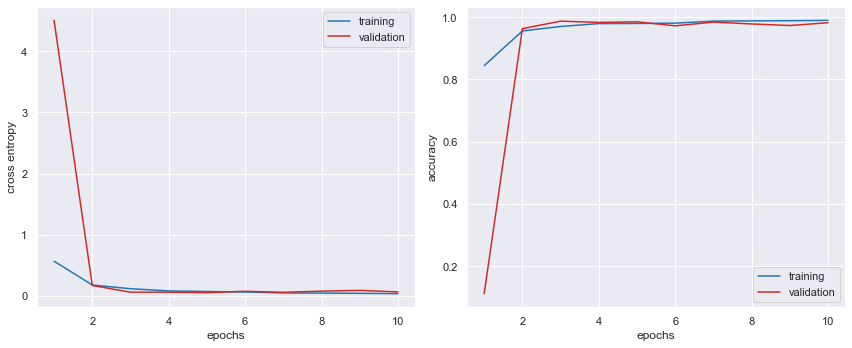

In [50]:
_, ax = subplots(ncols=2)

sns.lineplot(x=range(1, 11),
             y=hst.history['loss'],
             linestyle='-',
             color='tab:blue',
             label='training',
             ax=ax[0]
            )

sns.lineplot(x=range(1, 11),
             y=hst.history['val_loss'],
             linestyle='-',
             color='tab:red',
             label='validation',
             ax=ax[0]
            )

ax[0].set(xlabel='epochs', ylabel='cross entropy')

sns.lineplot(x=range(1, 11),
             y=hst.history['categorical_accuracy'],
             linestyle='-',
             color='tab:blue',
             label='training',
             ax=ax[1]
            )

sns.lineplot(x=range(1, 11),
             y=hst.history['val_categorical_accuracy'],
             linestyle='-',
             color='tab:red',
             label='validation',
             ax=ax[1]
            )

ax[1].set(xlabel='epochs', ylabel='accuracy')

plt.tight_layout()

E ancora una volta arriviamo ad ottenere un incremento di accuratezza dovuto all'abilità della rete di riconoscere particolari a partire direttamente dall'immagine.

In [51]:
y_pred = cnn.predict(X_test)

acc = accuracy_score(y_test, np.argmax(y_pred, axis=-1).ravel())
print(f'Accuracy score: {100 * acc:.1f}%')

Accuracy score: 98.1%


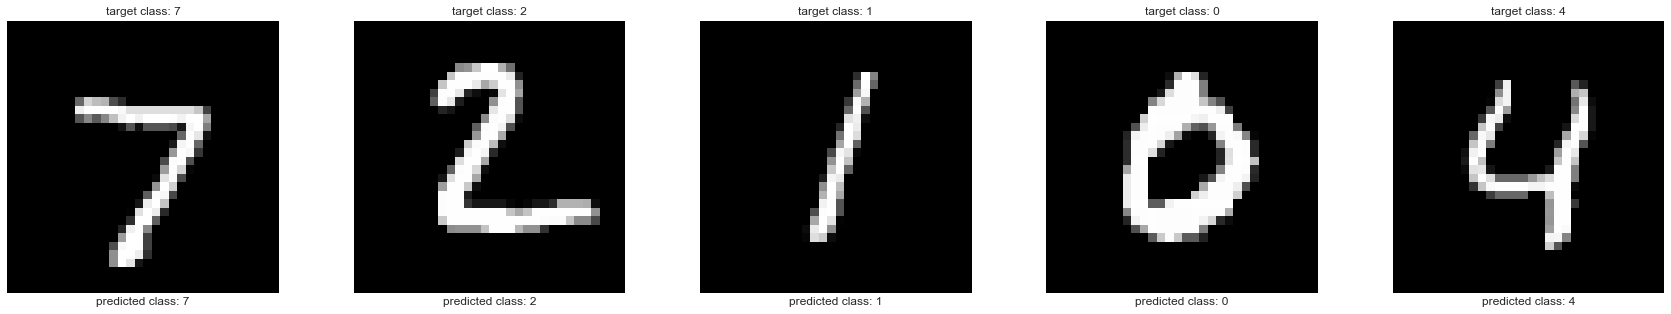

In [52]:
_, ax = subplots(1, 5, sharey=True)

for n in range(5):
    
    sns.heatmap(data=X_test[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    ax[n].set(title=f'target class: {y_test[n]:d}',
              xlabel=f'predicted class: {np.argmax(y_pred, axis=-1).ravel()[n]:d}'
             )

Un altro **enorme vantaggio** di queste reti è la loro indipendenza dalla dimensione dell'input: questo significa che le loro applicazioni sono pressoché infinite ed estremamente versatili.

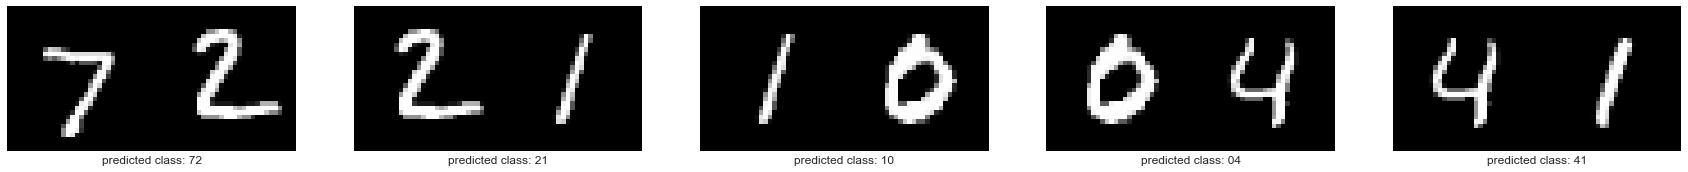

In [53]:
_, ax = subplots(ncols=5, sharey=True)

for n in range(5):

    conc = np.concatenate([X_test[n], X_test[n + 1]], axis=1)
    conc = conc.reshape(1, conc.shape[0], conc.shape[1], conc.shape[2])

    sns.heatmap(data=conc[0, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    pred = np.argmax(cnn.predict(conc), axis=-1).reshape(-1,)   
    
    ax[n].set(xlabel=f'predicted class: {pred[0]:d}{pred[-1]:d}')

### Autoencoder

Questo rappresenta un ultimo step prima di un modello di AI completo. Supponiamo di avere un **problema reale**: dovete riconoscere delle cifre scritte a mano ma queste sono **corrotte da molto rumore**.

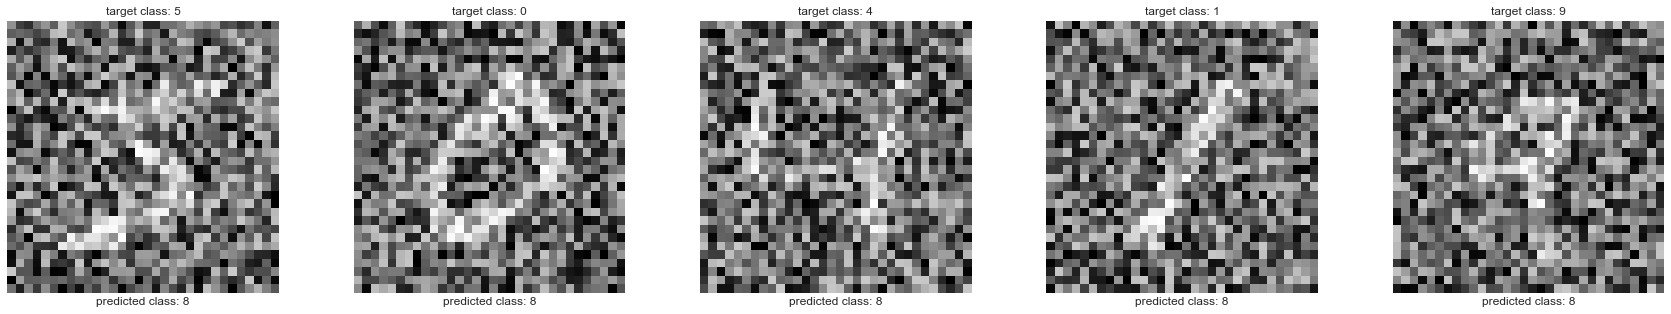

In [54]:
X_train_noise = X_train + 2.0 * np.random.uniform(size=X_train.shape)
X_val_noise   = X_val + 2.0 * np.random.uniform(size=X_val.shape)
X_test_noise  = X_test + 2.0 * np.random.uniform(size=X_test.shape)

tmp_pred = cnn.predict(X_train_noise)

_, ax = subplots(ncols=5, sharey=True)

for n in range(5):
    
    sns.heatmap(data=X_train_noise[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    ax[n].set(title=f'target class: {y_train[n]:d}',
              xlabel=f'predicted class: {np.argmax(tmp_pred, axis=-1).ravel()[n]:d}'
             )

Come si può notare, il nostro semplice modello di rete neurale precedente non riesce a predire nulla. E, ad essere sinceri, anche un umano potrebbe avere seri problemi a capire quali numeri si celano dietro tanto rumore.

Un architettura di tipo **autoencoder** è un metodo **unsupervised** basato su reti neurali che permette, come già visto, di riorganizzare l'input in modo tale da ricostruire una rappresentazione **migliore di quella di partenza**.

In [55]:
K.clear_session()

aenc = Sequential([Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', input_shape=(None, None, 1)),
                   MaxPool2D(pool_size=(2,2), padding='same'),
                   Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
                   MaxPool2D(pool_size=(2,2), padding='same'),
                   Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
                   MaxPool2D(pool_size=(2,2), padding='same'),
                   Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
                   UpSampling2D(size=(2,2)),
                   Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
                   UpSampling2D(size=(2,2)),
                   Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
                   UpSampling2D(size=(2,2)),
                   Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid'),
                  ],
                  name='autoencoder'
                 )

aenc.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 128)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    

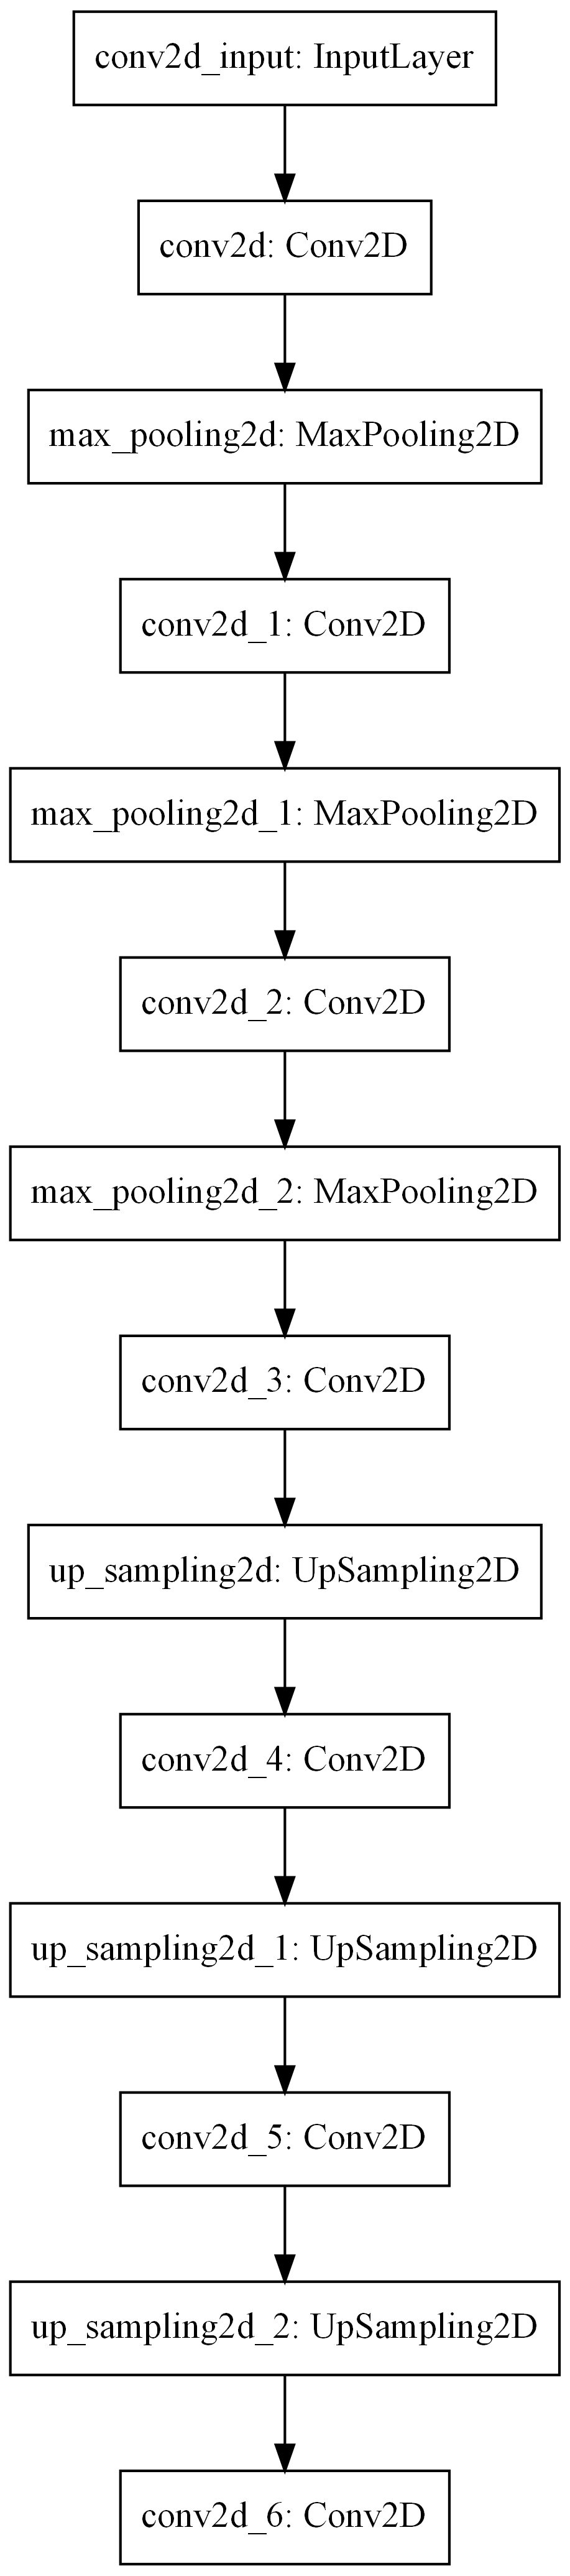

In [56]:
aenc_dot = model_to_dot(aenc, dpi=300)
Image(aenc_dot.create_png(), width=320)

In [57]:
aenc.compile(optimizer=Adam(learning_rate=1.0e-3),
            loss=BinaryCrossentropy(),
            metrics=[BinaryAccuracy()]
           )

hst = aenc.fit(x=X_train_noise,
               y=X_train,
               batch_size=32,
               epochs=10,
               validation_data=(X_val_noise, X_val),
               callbacks=[ModelCheckpoint('./aenc.h5', save_best_only=True)]
             )

aenc.load_weights('./aenc.h5')

Epoch 1/10
313/313 [==============================] - 22s 69ms/step - loss: 0.1833 - binary_accuracy: 0.8442 - val_loss: 0.1395 - val_binary_accuracy: 0.8408
Epoch 2/10
313/313 [==============================] - 23s 72ms/step - loss: 0.1287 - binary_accuracy: 0.8467 - val_loss: 0.1178 - val_binary_accuracy: 0.8418
Epoch 3/10
313/313 [==============================] - 23s 72ms/step - loss: 0.1134 - binary_accuracy: 0.8499 - val_loss: 0.1088 - val_binary_accuracy: 0.8476
Epoch 4/10
313/313 [==============================] - 22s 69ms/step - loss: 0.1055 - binary_accuracy: 0.8515 - val_loss: 0.1016 - val_binary_accuracy: 0.8467
Epoch 5/10
313/313 [==============================] - 22s 69ms/step - loss: 0.1001 - binary_accuracy: 0.8526 - val_loss: 0.1001 - val_binary_accuracy: 0.8483
Epoch 6/10
313/313 [==============================] - 21s 68ms/step - loss: 0.0961 - binary_accuracy: 0.8532 - val_loss: 0.0950 - val_binary_accuracy: 0.8490
Epoch 7/10
313/313 [==============================] 

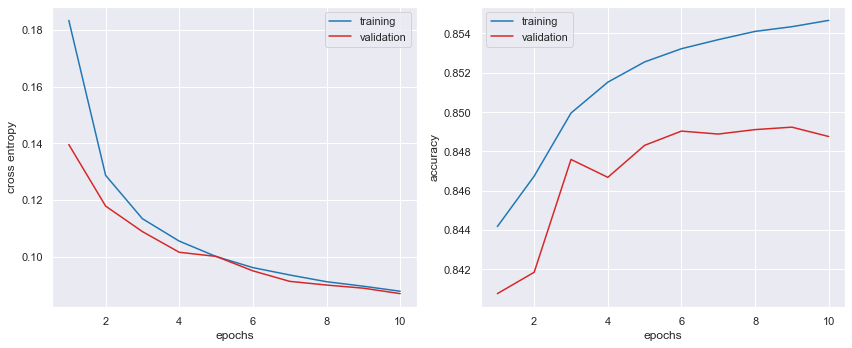

In [58]:
_, ax = subplots(ncols=2)

sns.lineplot(x=range(1, 11),
             y=hst.history['loss'],
             linestyle='-',
             color='tab:blue',
             label='training',
             ax=ax[0]
            )

sns.lineplot(x=range(1, 11),
             y=hst.history['val_loss'],
             linestyle='-',
             color='tab:red',
             label='validation',
             ax=ax[0]
            )

ax[0].set(xlabel='epochs', ylabel='cross entropy')

sns.lineplot(x=range(1, 11),
             y=hst.history['binary_accuracy'],
             linestyle='-',
             color='tab:blue',
             label='training',
             ax=ax[1]
            )

sns.lineplot(x=range(1, 11),
             y=hst.history['val_binary_accuracy'],
             linestyle='-',
             color='tab:red',
             label='validation',
             ax=ax[1]
            )

ax[1].set(xlabel='epochs', ylabel='accuracy')

plt.tight_layout()

I risultati sono molto positivi. La rete neurale è in grado di capire bene la distribuzione del rumore che copre i numeri scritti a mano e permette la ricostruzione delle cifre in maniera quasi perfetta.

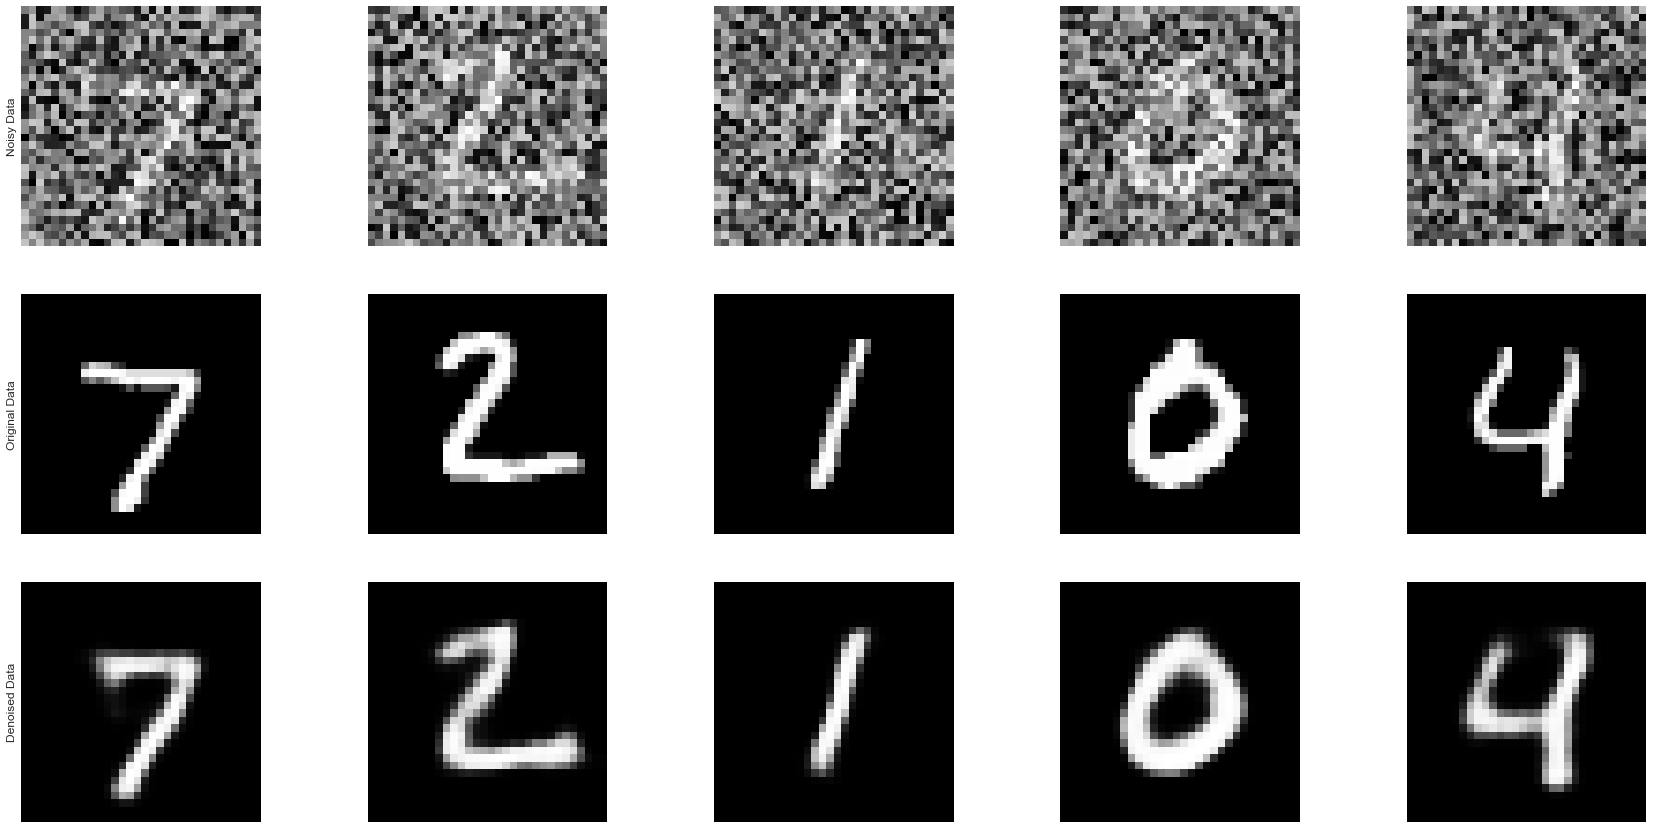

In [59]:
preds = aenc.predict(X_test_noise)

_, ax = subplots(nrows=3, ncols=5, sharey=True, sharex=True)

for n in range(5):
    
    sns.heatmap(data=X_test_noise[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[0, n]
               )
    
    sns.heatmap(data=X_test[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[1, n]
               )
    
    sns.heatmap(data=preds[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[2, n]
               )

ax[0, 0].set_ylabel('Noisy Data');
ax[1, 0].set_ylabel('Original Data');
ax[2, 0].set_ylabel('Denoised Data');

E come al solito, possiamo anche avere input di dimensioni diverse.

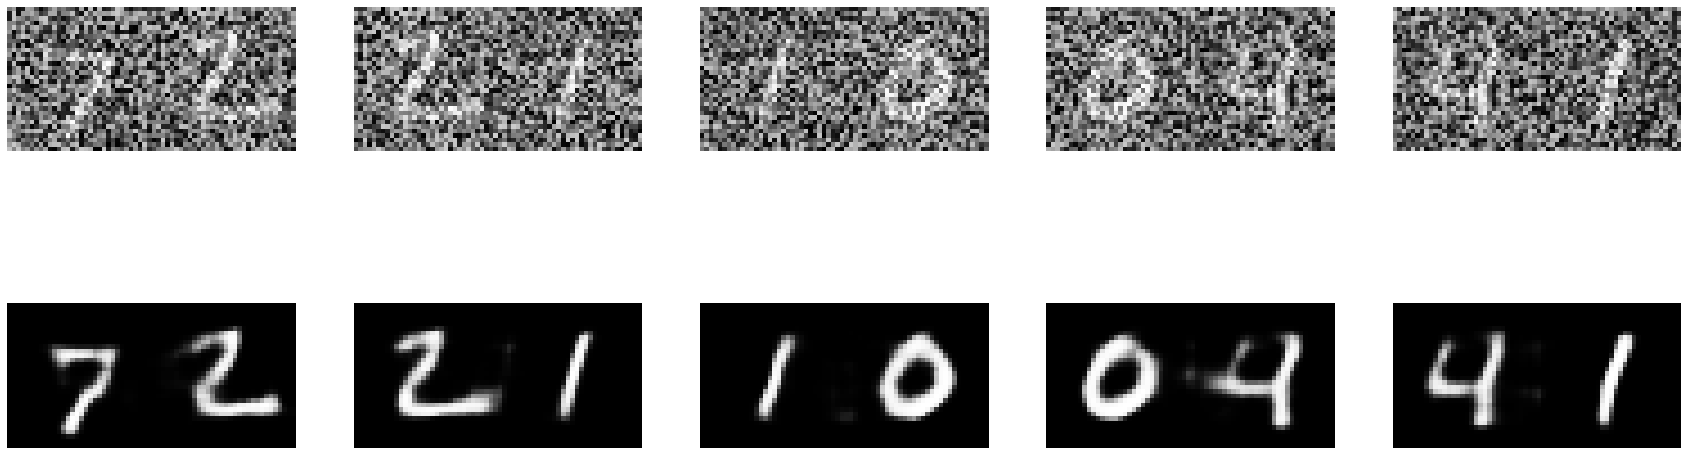

In [60]:
_, ax = subplots(nrows=2, ncols=5, sharex=True, sharey=True)

for n in range(5):

    conc_noise = np.concatenate([X_test_noise[n], X_test_noise[n + 1]], axis=1)
    conc_noise = conc_noise.reshape(1, conc_noise.shape[0], conc_noise.shape[1], conc_noise.shape[2])

    sns.heatmap(data=conc_noise[0, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[0, n]
               )
    
    pred = aenc.predict(conc_noise)
    
    sns.heatmap(data=pred[0, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[1, n]
               )

### AI Recognition

Siamo, a questo punto, pronti a creare il primo modellino di AI in grado di:

1. "dare un'occhiata" alle cifre e assegnare una classe,
2. "pulire" i dati in ingresso se necessario per permettere una migliore classificazione,
3. essere versatile sulla dimensione di input,
4. *molto probabilmente* battere in accuratezza anche un essere umano particolarmente attento (di sicuro è più veloce).

Interessante da notare, ciò che abbiamo implementato qui è un primo esempio (semplificato) di un algoritmo di tipo YOLO (= *You Only Look Once*), in grado di restituire il valore della classe corrispondente ad un particolare filtro.

In [61]:
K.clear_session()

ai = Model(inputs=aenc.input, outputs=cnn(aenc.output), trainable=False, name='ai_recognition')

Come possiamo notare l'accuratezza non è ai livelli del modello con l'input *pulito*, ma è comunque estremamente competitivo e permette di "fidarsi" delle predizioni.

In [62]:
y_pred = np.argmax(ai.predict(X_test_noise), axis=-1).ravel()

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy score: {100 * acc:.1f}%')

Accuracy score: 85.7%


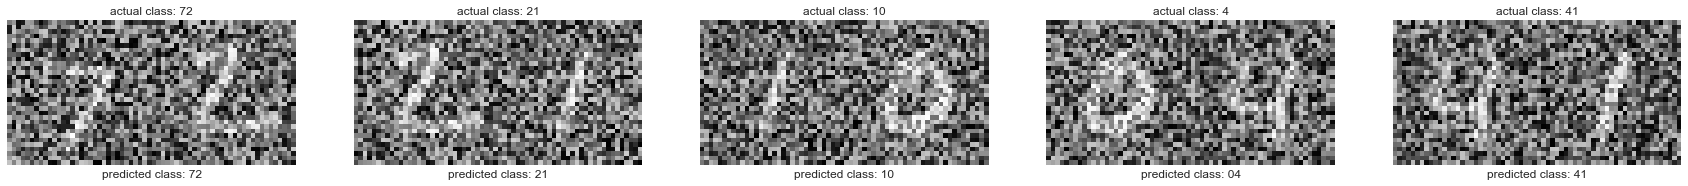

In [63]:
_, ax = subplots(ncols=5, sharey=True)

for n in range(5):

    conc_noise = np.concatenate([X_test_noise[n], X_test_noise[n + 1]], axis=1)
    conc_noise = conc_noise.reshape(1, conc_noise.shape[0], conc_noise.shape[1], conc_noise.shape[2])
    
    labels = y_test[n] * 10 + y_test[n + 1]

    sns.heatmap(data=conc_noise[0, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    pred = np.argmax(ai.predict(conc_noise), axis=-1).reshape(-1,)
    
    ax[n].set_title(f'actual class: {labels:d}')
    ax[n].set_xlabel(f'predicted class: {pred[0]:d}{pred[-1]:d}')